NOTE this notebook is just to fix some numbers for in the paper... Here we go!

# Number one: energy range

In [1]:
%run function_definitions.ipynb

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


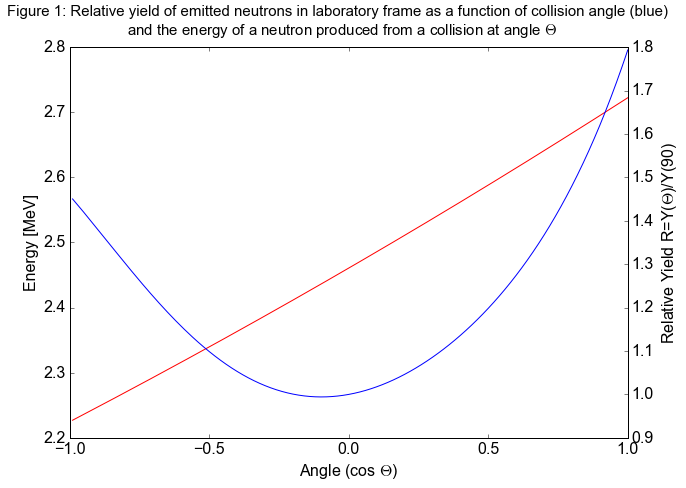

In [2]:
xE_points = []
yE_points = []
xCS_points = []
yCS_points = []
i =-1
for i in range (0, 200):
    x=(1-i/100)
    yE_points.append(2.46073+(0.24848*x+0.01282*np.power(x,2)+0.00031*np.power(x,3)))
    xE_points.append(x)
    yCS_points.append((1+0.11787*x+0.58355*np.power(x,2)+-0.11353*np.power(x,3)+0.0422*np.power(x,4)+0.16359*np.power(x,5)))
    xCS_points.append(x)

fig, ax1 = plt.subplots()
fig.suptitle("Figure 1: Relative yield of emitted neutrons in laboratory frame as a function of collision angle (blue) \n and the energy of a neutron produced from a collision at angle $\Theta$", size=15)
ax1.plot(xE_points, yE_points, color='red')
ax1.set_xlabel("Angle (cos $\Theta$)")
ax1.set_ylabel("Energy [MeV]")
ax1.set_ylim(2.2,2.8)
ax1.set_xlim(-1, 1)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(xCS_points, yCS_points, color='blue')
#ax2.set_xlabel("Angle (cos $\sigma$)")
ax2.set_ylabel("Relative Yield R=Y($\Theta$)/Y(90)")
ax2.set_ylim(0.9, 1.8)
ax2.set_xlim(-1, 1)
plt.show()

In [3]:
min(yE_points)

2.2269988893099999

In [4]:
max(yE_points)

2.72234

In [5]:
def yE(x):
    return 2.46073+(0.24848*x+0.01282*np.power(x,2)+0.00031*np.power(x,3))

In [6]:
# Minimum energy
yE(-1)

2.2247599999999998

In [7]:
# Maximum energy
yE(+1)

2.72234

# Scaling for simulation

In [65]:
# DD numbers
n_sim_dd   = 210e7 # Mail from JP September 8
n_at_ne_dd = 104603 # len(sim_energies)
f_useful_dd = n_at_ne_dd / n_sim_dd
a_dd = 0.005101508202512539

In [66]:
# DT numbers
n_sim_dt   = 9.5e8 # Mail from JP Nov 1
n_at_ne_dt = 20044 
f_useful_dt = n_at_ne_dt / n_sim_dt
a_dt = 0.043077878353139365

In [67]:
print(f_useful_dd, f_useful_dt)
# Why factor 2 different?

4.981095238095238e-05 2.1098947368421054e-05


In [77]:
# OK, here goes.
# Normalize scaling factor per number of events.
# Does this make sense? Well, suppose you have a giant number of events. Then your scaling factor becomes
# smaller and smaller. So, this should be up-corrected, i.e. multiplied by something proportional
# to the number of simulated events.
#
# Other way to look at it: the spectrum should be normalized before fitting, then the scaling factor corrects for
# this happening.
#
# Check: a INcreases if you DEcrease the statistics!
a_eff_dd = a_dd * n_sim_dd
a_eff_dt = a_dt * n_sim_dt

In [80]:
# Then, there is rebinning. 
# Lets get this straight. For the high energy, because of rebinning, the event rate is measured per 119 keVee.
# However, we use the same rebinning for the calculated response function and the simulated response! Right?
# NO. We do NOT rebin the response function! We calculate it using the reponse function.
# So. The factor a you need for dt is actually LOWER since you rebinned to make all values higher.
# This will give you a factor 50 or 25, depending on rebinning (discussed later)
a_eff_dt = a_eff_dt / 50
# 
# There is one final thing, we *may* be a factor of two off now :( because of the factor of 2 rebinning. What to do?
# Well, how about checking the non-rebinned factor?
# I checked. It is the same. So 50 is correct.

In [81]:
# Does this make sense? A large value of a means that you measure MORE. 
(a_eff_dt/a_eff_dd)

0.07639941312393136

### Comparison to AZ

In [ ]:
# This number is a bit higher that what AZ finds but he compares 2-2.8 MeV to 2.5 - 14.
# Lets check this.

In [83]:
def read_simulation(fn, col_n = 0):    
    # Relevant imports to reading in 
    import ROOT
    import root_numpy as rn

    # Actually read the root file
    f = ROOT.TFile(fn)
    treenames = rn.list_trees(fn)
    assert len(treenames) == 1
    tree = f.Get(treenames[0])
    data = rn.tree2array(tree)

    # Somehow the data is stored in the form of an array of tuples... wtf? So here's a hack to get it out!
    sim_energies = np.array([d[col_n] for d in data])
    print('Read a total of %d events from file %s.' % (len(sim_energies), fn))
    return sim_energies

In [87]:
e_at_ne_dt = np.concatenate([
    read_simulation('./simu/161101_14-1_MeV/NE213_DT_Spectrum.root'),
    read_simulation('./simu/161101_14-1_MeV/NE213_DT_Spectrum2.root'),
    read_simulation('./simu/161101_14-1_MeV/NE213_DT_Spectrum3.root'),
    read_simulation('./simu/161101_14-1_MeV/NE213_DT_Spectrum4.root')])/1000

Read a total of 3808 events from file ./simu/161101_14-1_MeV/NE213_DT_Spectrum.root.
Read a total of 3871 events from file ./simu/161101_14-1_MeV/NE213_DT_Spectrum2.root.
Read a total of 6103 events from file ./simu/161101_14-1_MeV/NE213_DT_Spectrum3.root.
Read a total of 6262 events from file ./simu/161101_14-1_MeV/NE213_DT_Spectrum4.root.


In [88]:
e_at_ne_dd = read_simulation('./simu/NE213_E_Spectrum.root')/1000

Read a total of 104603 events from file ./simu/NE213_E_Spectrum.root.


In [91]:
n_in_range_dd = len(e_at_ne_dd[(e_at_ne_dd > 2.0) & (e_at_ne_dd < 2.8) ])
n_in_range_dt = len(e_at_ne_dt[(e_at_ne_dt > 2.5)])

In [100]:
f_in_range_dt = n_in_range_dt / len(e_at_ne_dt)

In [99]:
f_in_range_dd = n_in_range_dd / len(e_at_ne_dd)

In [105]:
((a_eff_dt * f_in_range_dt) / (a_eff_dd * f_in_range_dd)) # Fraction in range almost cancels (by chance?)

0.0749639895871028

In [106]:
((a_eff_dt * f_in_range_dt) / (a_eff_dd * f_in_range_dd)) * f_useful_dt / f_useful_dd 
# the fraction useful converts the number simulated to the number at the NE213

0.03175328306772087

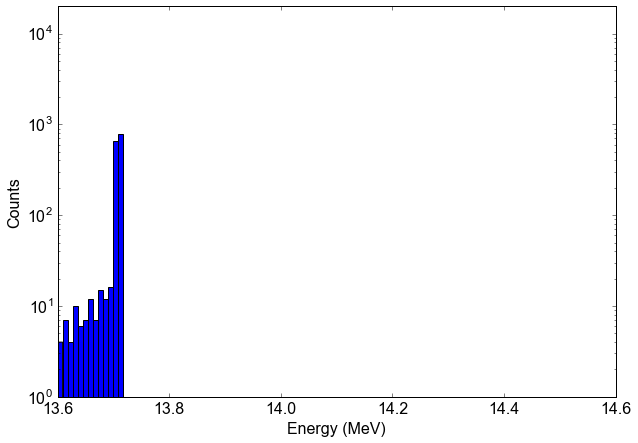

In [46]:
plt.hist(a/1000, bins=100, range=(13.6,14.5));
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(1,2e4)
plt.savefig('to_14_MeV_or_not_to_14_MeV_new.png')